# Metrics of Fine tuning Mini-Replica without augmented images

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.insert(0, "./../../../src/utils/")
from utils import winapi_path

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
data_dir = "./../../../data/model_learning/"
scores_dir = data_dir + "scores/"
losses_dir = data_dir + "losses/"
lr_dir = data_dir + "learning_rates/"

scores_folder = "scores_lft-resnext-101_280_batch-4_adam_e-6_steplr_10-0.1_Marg-0.7_triplets-10_without-aug-images"
losses_folder = "losses_lft-resnext-101_280_batch-4_adam_e-6_steplr_10-0.1_Marg-0.7_triplets-10_without-aug-images"
lr_folder = "lr_lft-resnext-101_280_batch-4_adam_e-6_steplr_10-0.1_Marg-0.7_triplets-10_without-aug-images"
train_param = "Mini-Replica Resnext-101, 280 res, Batch 4, adam_e-6, steplr_10-0.1, Loss Marg-0.7, 10 triplets, without aug images"

In [2]:
def read_losses_scores_lr(curr_losses_folder, curr_scores_folder, curr_lr_folder, split_id):
    
    if split_id:
        curr_scores_folder = curr_scores_folder + "_v" + str(split_id) + "/"
        curr_losses_folder = curr_losses_folder + "_v" + str(split_id) + "/"
        curr_lr_folder = curr_lr_folder + "_v" + str(split_id) + "/"
    else:    
        curr_scores_folder = curr_scores_folder + "/"
        curr_losses_folder = curr_losses_folder + "/"
        curr_lr_folder = curr_lr_folder + "/"
        
    
    train_loss = pd.read_csv(winapi_path(losses_dir + curr_losses_folder + "train_loss.csv"))
    val_loss = pd.read_csv(winapi_path(losses_dir + curr_losses_folder + "validation_loss.csv"))


    train_scores = pd.read_csv(winapi_path(scores_dir + curr_scores_folder + "train_scores.csv"))
    val_scores = pd.read_csv(winapi_path(scores_dir + curr_scores_folder + "validation_scores.csv"))
    test_scores = pd.read_csv(winapi_path(scores_dir + curr_scores_folder + "test_scores.csv"))
    non_train_scores = pd.read_csv(winapi_path(scores_dir + curr_scores_folder + "test-and-val_scores.csv"))
    
    learning_rates = pd.read_csv(winapi_path(lr_dir + curr_lr_folder + "learning_rate.csv"))
    
    return train_loss, val_loss, train_scores, val_scores, test_scores, non_train_scores, learning_rates


def highlight_df_scores(score_df):
    return (score_df.style.highlight_min(color = 'lightgreen', axis = 0, subset=['mean_position','mean_min_position', 'mean_median_position'])
 .highlight_max(color = 'lightblue', axis = 0, subset=['map','recall_400', 'recall_200', 'recall_100', 'recall_50', 'recall_20']))


def plot_mean_position(train_df, val_df, test_df, test_val_df, train_param):
    plts = plt.figure(figsize=(9, 6))
    plt.plot(train_df['mean_position'], label="train")
    if val_df is not None:
        plt.plot(val_df['mean_position'], label="validation")
    if test_df is not None:
        plt.plot(test_df['mean_position'], label="test")
    if test_val_df is not None:
        plt.plot(test_val_df['mean_position'], label="Non-Train")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Position of retrived artwork")
    plt.legend()
    plt.title("Average position of the expected artwork in the list of retrived artworks")
    plt.suptitle(train_param)
    plt.grid()
    plts.tight_layout()
    
    
def plot_recall_at_k(train_df, val_df, test_df, test_val_df, train_param, recall_columns = ['recall_400', 'recall_200', 'recall_100', 'recall_50', 'recall_20']):

    plts = plt.figure(figsize=(15, 9))
    ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=plts)
    ax2 = plt.subplot2grid((2,6), (0,2), colspan=2, fig=plts, sharey=ax1)
    ax3 = plt.subplot2grid((2,6), (0,4), colspan=2, fig=plts, sharey=ax1)
    ax4 = plt.subplot2grid((2,6), (1,1), colspan=2, fig=plts, sharey=ax1)
    ax5 = plt.subplot2grid((2,6), (1,3), colspan=2, fig=plts, sharey=ax1)

    axs = [ax1, ax2, ax3, ax4, ax5]

    for num, name in enumerate(recall_columns):

        axs[num].plot(train_df[name], label="train")
        axs[num].plot(val_df[name], label="validation")
        axs[num].plot(test_df[name], label="test")
        if test_val_df is not None:
            axs[num].plot(test_val_df[name], label="non-train")
        axs[num].set_xlabel("Epoch")
        axs[num].set_ylabel(name)
        axs[num].legend()
        axs[num].set_title(name.replace("_", "@").replace("recall", "Recall"))
        axs[num].grid()


    plts.suptitle("{}\nRecall@k".format(train_param))
    plt.yticks(np.linspace(0, 1, 11))
    plt.margins(x=0.02)
    plts.tight_layout()
    
    
def get_averaged_df(score_dataframe):
    a = score_dataframe.groupby("model").agg(['mean', 'std'])
    a.columns = list(map('_'.join, a.columns.values))
    a["MP"] = round(a["MP_mean"], 2).astype(str) + " ± " + round(a["MP_std"], 2).astype(str)
    a["MMP"] = round(a["MMP_mean"], 2).astype(str) + " ± " + round(a["MMP_std"], 2).astype(str)
    a["mean_median_position"] = round(a["mean_median_position_mean"], 2).astype(str) + " ± " + round(a["mean_median_position_std"], 2).astype(str)
    a["MAP"] = round(a["MAP_mean"], 2).astype(str) + " ± " + round(a["MAP_std"], 2).astype(str)
    a["R@400"] = round(a["R@400_mean"], 2).astype(str) + " ± " + round(a["R@400_std"], 2).astype(str)
    a["R@200"] = round(a["R@200_mean"], 2).astype(str) + " ± " + round(a["R@200_std"], 2).astype(str)
    a["R@100"] = round(a["R@100_mean"], 2).astype(str) + " ± " + round(a["R@100_std"], 2).astype(str)
    a["R@50"] = round(a["R@50_mean"], 2).astype(str) + " ± " + round(a["R@50_std"], 2).astype(str)
    a["R@20"] = round(a["R@20_mean"], 2).astype(str) + " ± " + round(a["R@20_std"], 2).astype(str)

    b = a[["MP", "MMP", 'MAP','R@400', 'R@200', 'R@100', 'R@50', 'R@20']].reset_index()
    score_dataframe_avg_df = b.replace({"resnet": "ResNet-101", "resnext": "ResNeXT-101"})
    
    return score_dataframe_avg_df

In [4]:
train_metrics, val_metrics, test_metrics, non_train_metrics = [], [], [], []

## Data Split - v0

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,450.826316,450.311828,439.392473,0.256801,0.774194,0.666667,0.569892,0.526882,0.451613
1,322.247368,176.677419,294.166667,0.327881,0.838710,0.763441,0.688172,0.612903,0.537634
2,288.242105,115.182796,263.387097,0.460122,0.913978,0.870968,0.817204,0.709677,0.677419
3,276.036842,86.935484,244.553763,0.559946,0.935484,0.924731,0.881720,0.849462,0.806452
4,251.773684,61.752688,231.134409,0.595508,0.935484,0.924731,0.903226,0.870968,0.827957
5,231.042105,36.129032,218.193548,0.667903,0.967742,0.935484,0.935484,0.903226,0.870968
6,216.910526,14.440860,207.284946,0.745627,0.978495,0.956989,0.956989,0.935484,0.913978
7,211.047368,11.688172,205.908602,0.795759,0.978495,0.967742,0.956989,0.935484,0.924731
8,218.315789,11.010753,205.548387,0.790834,0.989247,0.978495,0.946237,0.903226,0.903226
9,203.336842,2.881720,201.462366,0.839255,0.989247,0.989247,0.978495,0.978495,0.967742


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,782.625000,1247.526316,802.815789,0.427962,0.631579,0.631579,0.578947,0.526316,0.473684
1,605.100000,873.789474,615.947368,0.356279,0.736842,0.684211,0.631579,0.631579,0.526316
2,613.725000,891.947368,625.026316,0.390045,0.736842,0.736842,0.736842,0.684211,0.578947
3,519.400000,693.052632,525.894737,0.413515,0.736842,0.736842,0.736842,0.736842,0.631579
4,556.850000,772.000000,565.263158,0.410938,0.736842,0.736842,0.736842,0.736842,0.526316
5,390.000000,420.947368,389.526316,0.443371,0.842105,0.736842,0.736842,0.736842,0.631579
6,341.250000,318.315789,338.210526,0.458992,0.789474,0.789474,0.684211,0.684211,0.684211
7,342.325000,320.578947,339.342105,0.440695,0.789474,0.789474,0.684211,0.684211,0.684211
8,403.250000,447.789474,403.947368,0.364224,0.842105,0.789474,0.736842,0.631579,0.526316
9,368.225000,375.000000,366.657895,0.449614,0.789474,0.789474,0.684211,0.684211,0.684211


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,267.150000,118.736842,275.000000,0.444401,0.789474,0.789474,0.631579,0.631579,0.631579
1,451.275000,535.736842,458.236842,0.509246,0.842105,0.736842,0.684211,0.631579,0.631579
2,441.150000,523.684211,445.368421,0.477772,0.842105,0.789474,0.789474,0.736842,0.631579
3,422.050000,484.105263,425.263158,0.492186,0.894737,0.894737,0.736842,0.736842,0.631579
4,442.775000,529.315789,446.184211,0.522471,0.894737,0.842105,0.736842,0.736842,0.631579
5,420.850000,482.736842,423.368421,0.470068,0.894737,0.894737,0.842105,0.736842,0.631579
6,398.050000,434.526316,399.157895,0.475929,0.894737,0.894737,0.894737,0.684211,0.631579
7,399.475000,438.473684,399.657895,0.473222,0.894737,0.894737,0.894737,0.789474,0.631579
8,429.600000,499.157895,433.157895,0.463589,0.894737,0.894737,0.894737,0.684211,0.631579
9,418.150000,469.684211,423.736842,0.524686,0.894737,0.894737,0.842105,0.736842,0.684211


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,524.887500,683.131579,538.907895,0.436181,0.710526,0.710526,0.605263,0.578947,0.552632
1,528.187500,704.763158,537.092105,0.432762,0.789474,0.710526,0.657895,0.631579,0.578947
2,527.437500,707.815789,535.197368,0.433909,0.789474,0.763158,0.763158,0.710526,0.605263
3,470.725000,588.578947,475.578947,0.452850,0.815789,0.815789,0.736842,0.736842,0.631579
4,499.812500,650.657895,505.723684,0.466705,0.815789,0.789474,0.736842,0.736842,0.578947
5,405.425000,451.842105,406.447368,0.456719,0.868421,0.815789,0.789474,0.736842,0.631579
6,369.650000,376.421053,368.684211,0.467460,0.842105,0.842105,0.789474,0.684211,0.657895
7,370.900000,379.526316,369.500000,0.456958,0.842105,0.842105,0.789474,0.736842,0.657895
8,416.425000,473.473684,418.552632,0.413907,0.868421,0.842105,0.815789,0.657895,0.578947
9,393.187500,422.342105,395.197368,0.487150,0.842105,0.842105,0.763158,0.710526,0.684211


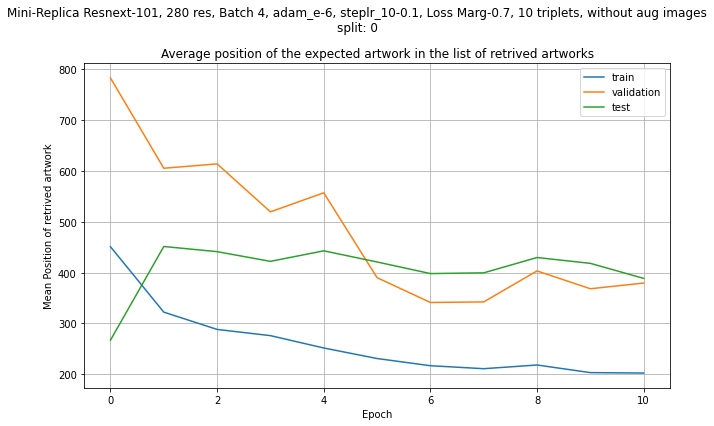

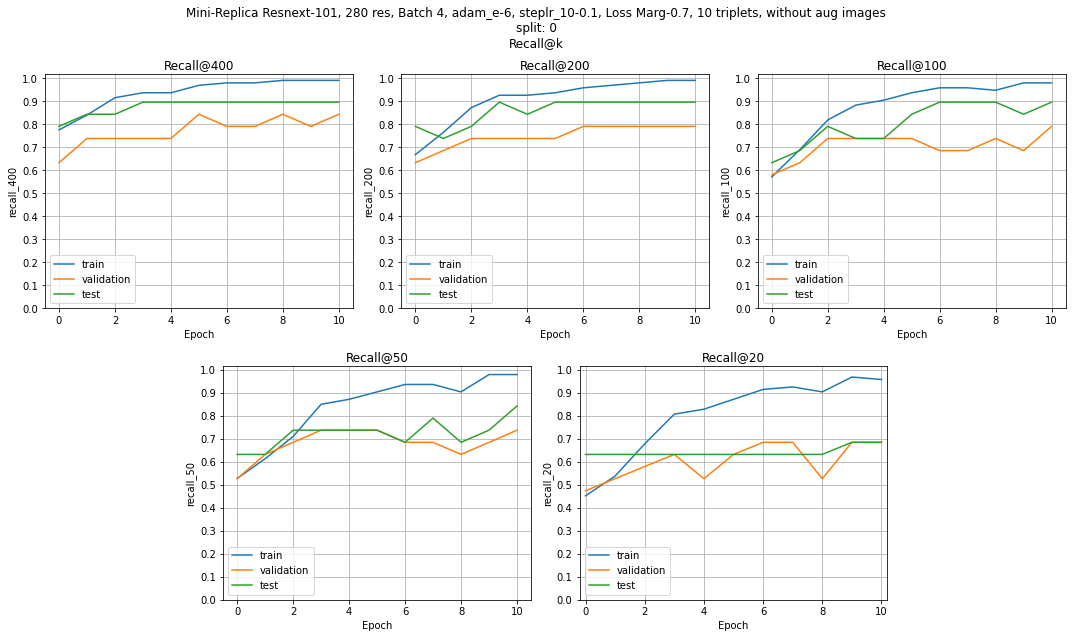

In [5]:
split_id = 0

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [6]:
best_epoch = 6

train_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v1

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,452.898810,458.462500,444.518750,0.334862,0.737500,0.687500,0.575000,0.562500,0.512500
1,424.571429,356.250000,372.225000,0.380593,0.837500,0.762500,0.687500,0.650000,0.525000
2,381.940476,301.925000,347.887500,0.464815,0.850000,0.800000,0.750000,0.712500,0.625000
3,296.773810,167.550000,275.125000,0.510629,0.925000,0.875000,0.812500,0.775000,0.700000
4,300.500000,132.275000,256.812500,0.601759,0.950000,0.937500,0.887500,0.837500,0.800000
5,258.041667,62.887500,221.731250,0.679357,0.962500,0.950000,0.900000,0.900000,0.825000
6,274.238095,107.475000,244.112500,0.713962,0.962500,0.950000,0.925000,0.912500,0.887500
7,238.214286,32.375000,206.562500,0.765571,0.975000,0.950000,0.937500,0.925000,0.900000
8,225.898810,11.812500,196.006250,0.819406,0.975000,0.975000,0.950000,0.937500,0.937500
9,216.773810,13.400000,196.850000,0.830903,0.975000,0.975000,0.975000,0.975000,0.937500


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,566.000000,732.000000,566.000000,0.245349,0.766667,0.566667,0.466667,0.333333,0.266667
1,425.350000,450.700000,425.350000,0.252351,0.866667,0.800000,0.566667,0.433333,0.300000
2,425.066667,450.133333,425.066667,0.257228,0.900000,0.800000,0.633333,0.566667,0.466667
3,347.683333,295.366667,347.683333,0.229062,0.900000,0.866667,0.633333,0.566667,0.433333
4,374.516667,349.033333,374.516667,0.245468,0.900000,0.700000,0.566667,0.533333,0.366667
5,325.783333,251.566667,325.783333,0.232725,0.900000,0.833333,0.666667,0.600000,0.433333
6,370.833333,341.666667,370.833333,0.278866,0.900000,0.833333,0.633333,0.533333,0.366667
7,367.550000,335.100000,367.550000,0.280164,0.900000,0.733333,0.666667,0.566667,0.366667
8,345.183333,290.366667,345.183333,0.275073,0.866667,0.700000,0.700000,0.633333,0.533333
9,345.133333,290.266667,345.133333,0.281197,0.900000,0.733333,0.700000,0.600000,0.400000


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,419.071429,438.142857,419.071429,0.300380,0.809524,0.809524,0.761905,0.761905,0.666667
1,434.142857,468.285714,434.142857,0.347389,0.857143,0.809524,0.666667,0.619048,0.476190
2,433.452381,466.904762,433.452381,0.378300,0.857143,0.809524,0.714286,0.666667,0.523810
3,354.190476,308.380952,354.190476,0.394861,0.904762,0.857143,0.761905,0.666667,0.619048
4,385.642857,371.285714,385.642857,0.373439,0.904762,0.809524,0.714286,0.714286,0.666667
5,410.190476,420.380952,410.190476,0.337905,0.857143,0.857143,0.571429,0.571429,0.523810
6,349.523810,299.047619,349.523810,0.465700,0.857143,0.714286,0.666667,0.666667,0.619048
7,377.261905,354.523810,377.261905,0.384508,0.952381,0.809524,0.714286,0.666667,0.619048
8,368.690476,337.380952,368.690476,0.389056,0.904762,0.809524,0.761905,0.666667,0.571429
9,365.785714,331.571429,365.785714,0.388201,0.904762,0.761905,0.714286,0.714286,0.619048


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,505.500000,611.000000,505.500000,0.268009,0.784314,0.666667,0.588235,0.509804,0.431373
1,428.970588,457.941176,428.970588,0.291484,0.862745,0.803922,0.607843,0.509804,0.372549
2,428.519608,457.039216,428.519608,0.307081,0.882353,0.803922,0.666667,0.607843,0.490196
3,350.362745,300.725490,350.362745,0.297332,0.901961,0.862745,0.686275,0.607843,0.509804
4,379.098039,358.196078,379.098039,0.298162,0.901961,0.745098,0.627451,0.607843,0.490196
5,360.539216,321.078431,360.539216,0.276035,0.882353,0.843137,0.627451,0.588235,0.470588
6,362.058824,324.117647,362.058824,0.355798,0.882353,0.784314,0.647059,0.588235,0.470588
7,371.549020,343.098039,371.549020,0.323129,0.921569,0.764706,0.686275,0.607843,0.470588
8,354.862745,309.725490,354.862745,0.322007,0.882353,0.745098,0.725490,0.647059,0.549020
9,353.637255,307.274510,353.637255,0.325257,0.901961,0.745098,0.705882,0.647059,0.490196


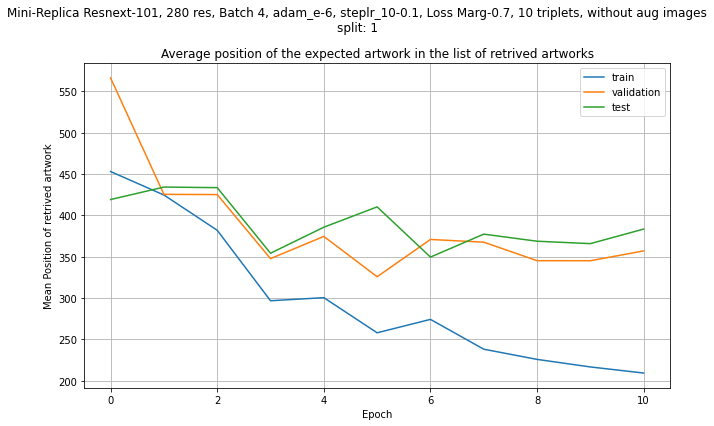

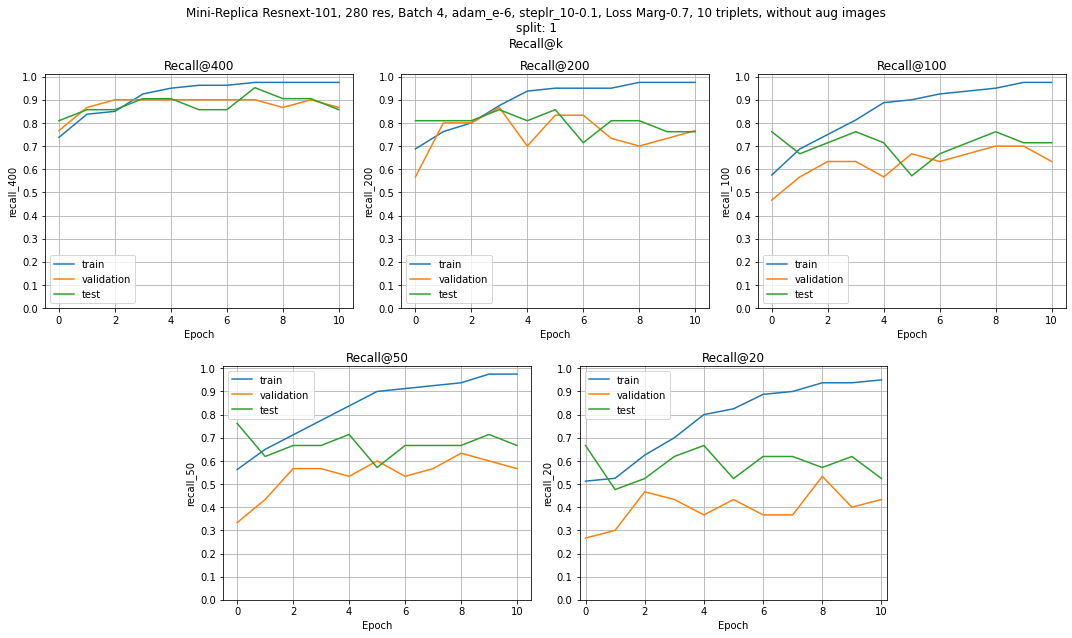

In [7]:
split_id = 1

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [8]:
best_epoch = 8

train_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v2

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,448.652941,449.890244,436.237805,0.377627,0.792683,0.756098,0.658537,0.646341,0.573171
1,391.335294,315.573171,360.225610,0.403493,0.878049,0.804878,0.731707,0.707317,0.621951
2,329.029412,233.914634,316.323171,0.470078,0.890244,0.829268,0.817073,0.768293,0.695122
3,300.576471,147.097561,269.060976,0.584461,0.902439,0.865854,0.853659,0.829268,0.768293
4,262.576471,90.975610,240.853659,0.674937,0.914634,0.878049,0.865854,0.853659,0.829268
5,247.305882,67.219512,228.792683,0.695175,0.963415,0.963415,0.914634,0.890244,0.853659
6,211.229412,11.841463,201.067073,0.779772,0.987805,0.975610,0.951220,0.914634,0.865854
7,211.811765,23.317073,206.817073,0.801793,0.975610,0.975610,0.963415,0.939024,0.902439
8,205.723529,7.817073,199.091463,0.834644,0.987805,0.975610,0.963415,0.951220,0.951220
9,202.305882,7.146341,198.731707,0.839029,0.975610,0.975610,0.963415,0.963415,0.951220


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,564.954545,729.909091,564.954545,0.283134,0.636364,0.590909,0.500000,0.500000,0.500000
1,514.954545,629.909091,514.954545,0.340982,0.681818,0.681818,0.590909,0.454545,0.409091
2,463.227273,526.454545,463.227273,0.306205,0.636364,0.590909,0.545455,0.500000,0.363636
3,534.954545,669.909091,534.954545,0.267915,0.681818,0.636364,0.590909,0.590909,0.409091
4,521.818182,643.636364,521.818182,0.324690,0.727273,0.727273,0.590909,0.454545,0.363636
5,451.590909,503.181818,451.590909,0.287393,0.727273,0.681818,0.545455,0.454545,0.363636
6,505.636364,611.272727,505.636364,0.259203,0.727273,0.681818,0.681818,0.545455,0.454545
7,445.818182,491.636364,445.818182,0.358141,0.772727,0.681818,0.636364,0.590909,0.500000
8,408.954545,417.909091,408.954545,0.351260,0.818182,0.636364,0.590909,0.590909,0.454545
9,384.204545,368.409091,384.204545,0.342701,0.772727,0.727273,0.590909,0.545455,0.500000


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,473.553571,551.444444,486.722222,0.120852,0.740741,0.518519,0.407407,0.259259,0.185185
1,357.607143,339.555556,356.888889,0.155253,0.851852,0.703704,0.592593,0.481481,0.296296
2,354.803571,335.222222,353.166667,0.171853,0.814815,0.703704,0.666667,0.592593,0.407407
3,416.071429,459.925926,417.851852,0.180217,0.814815,0.666667,0.555556,0.481481,0.296296
4,355.821429,336.888889,354.666667,0.197951,0.962963,0.814815,0.666667,0.518519,0.296296
5,393.321429,413.407407,394.074074,0.159918,0.814815,0.703704,0.629630,0.555556,0.333333
6,380.678571,385.629630,381.518519,0.192199,0.888889,0.814815,0.592593,0.444444,0.296296
7,392.482143,413.518519,392.425926,0.236474,0.925926,0.703704,0.555556,0.518519,0.370370
8,370.607143,368.222222,369.740741,0.272285,0.888889,0.740741,0.666667,0.518519,0.407407
9,368.160714,362.925926,367.129630,0.190670,0.888889,0.814815,0.629630,0.592593,0.444444


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,513.770000,631.571429,521.846939,0.193713,0.693878,0.551020,0.448980,0.367347,0.326531
1,426.840000,469.918367,427.857143,0.238642,0.775510,0.693878,0.591837,0.469388,0.346939
2,402.510000,421.081633,402.581633,0.232175,0.734694,0.653061,0.612245,0.551020,0.387755
3,468.380000,554.204082,470.428571,0.219591,0.755102,0.653061,0.571429,0.530612,0.346939
4,428.860000,474.612245,429.714286,0.254854,0.857143,0.775510,0.632653,0.489796,0.326531
5,418.960000,453.714286,419.897959,0.217151,0.775510,0.693878,0.591837,0.510204,0.346939
6,435.660000,486.938776,437.244898,0.222282,0.816327,0.755102,0.632653,0.489796,0.367347
7,415.950000,448.591837,416.397959,0.291100,0.857143,0.693878,0.591837,0.551020,0.428571
8,387.480000,390.530612,387.346939,0.307743,0.857143,0.693878,0.632653,0.551020,0.428571
9,375.220000,365.387755,374.795918,0.258929,0.836735,0.775510,0.612245,0.571429,0.469388


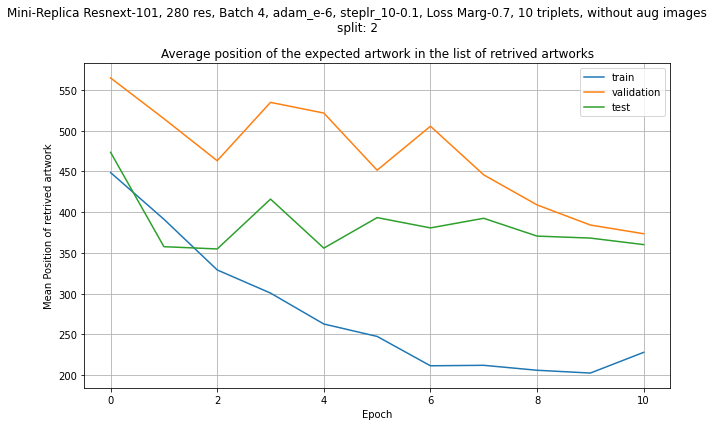

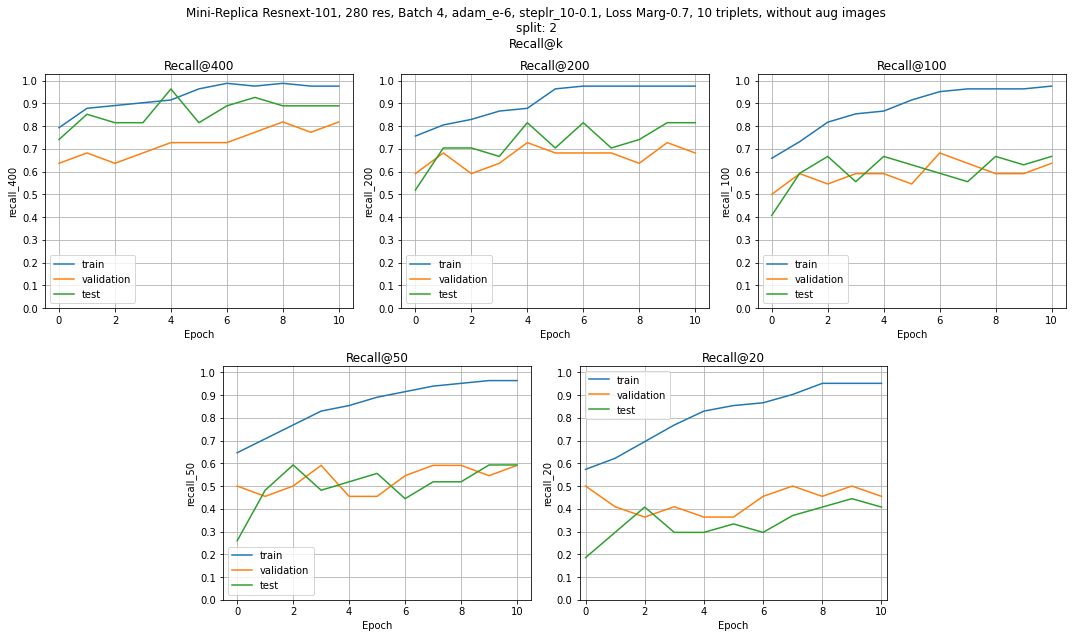

In [9]:
split_id = 2

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [10]:
best_epoch = 9

train_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v3

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,446.583333,504.740260,447.201299,0.396621,0.818182,0.779221,0.688312,0.662338,0.610390
1,307.980769,223.727273,306.902597,0.382948,0.831169,0.831169,0.792208,0.727273,0.623377
2,279.647436,166.532468,278.097403,0.520625,0.922078,0.870130,0.818182,0.792208,0.701299
3,240.506410,87.233766,238.448052,0.639316,0.948052,0.922078,0.870130,0.818182,0.779221
4,231.250000,68.480519,229.071429,0.692958,0.961039,0.935065,0.909091,0.883117,0.844156
5,213.839744,33.207792,211.435065,0.729539,0.974026,0.974026,0.961039,0.883117,0.883117
6,203.705128,12.675325,201.168831,0.806131,0.987013,0.987013,0.974026,0.935065,0.883117
7,201.012821,7.220779,198.441558,0.802219,1.000000,0.987013,0.987013,0.961039,0.922078
8,201.557692,8.324675,198.993506,0.772579,1.000000,1.000000,0.961039,0.935065,0.909091
9,200.673077,6.532468,198.097403,0.825871,1.000000,1.000000,0.974026,0.948052,0.922078


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,445.050000,425.689655,421.741379,0.139114,0.724138,0.517241,0.413793,0.310345,0.241379
1,449.300000,511.586207,458.689655,0.214749,0.758621,0.655172,0.448276,0.344828,0.206897
2,340.850000,293.413793,343.327586,0.193276,0.793103,0.724138,0.620690,0.517241,0.310345
3,355.833333,325.793103,359.344828,0.159242,0.793103,0.724138,0.586207,0.448276,0.241379
4,300.216667,209.000000,301.844828,0.191307,0.862069,0.758621,0.517241,0.413793,0.310345
5,295.666667,191.586207,301.068966,0.216143,0.827586,0.724138,0.689655,0.620690,0.448276
6,305.516667,224.172414,305.913793,0.197120,0.862069,0.758621,0.586207,0.448276,0.275862
7,299.083333,191.000000,308.189655,0.173363,0.827586,0.793103,0.620690,0.517241,0.310345
8,271.350000,152.724138,270.155172,0.155298,0.896552,0.827586,0.655172,0.551724,0.275862
9,264.800000,132.000000,267.206897,0.187566,0.862069,0.793103,0.724138,0.620690,0.413793


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,579.222222,665.120000,587.080000,0.235329,0.600000,0.560000,0.440000,0.440000,0.360000
1,676.703704,665.840000,533.400000,0.266420,0.720000,0.680000,0.600000,0.520000,0.480000
2,745.277778,734.360000,566.940000,0.261300,0.720000,0.680000,0.640000,0.560000,0.360000
3,710.944444,748.200000,568.740000,0.241576,0.800000,0.640000,0.600000,0.480000,0.360000
4,714.944444,669.240000,534.260000,0.267241,0.760000,0.680000,0.680000,0.600000,0.400000
5,625.814815,617.680000,510.240000,0.290196,0.800000,0.800000,0.720000,0.680000,0.520000
6,698.722222,637.560000,518.100000,0.275318,0.800000,0.760000,0.720000,0.600000,0.440000
7,729.888889,660.960000,530.120000,0.268119,0.800000,0.760000,0.720000,0.640000,0.520000
8,824.851852,1031.680000,720.760000,0.256836,0.720000,0.680000,0.680000,0.520000,0.360000
9,747.185185,745.600000,571.800000,0.297108,0.800000,0.760000,0.680000,0.640000,0.520000


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,508.605263,536.537037,498.287037,0.183658,0.666667,0.537037,0.425926,0.370370,0.296296
1,557.017544,583.000000,493.277778,0.238671,0.740741,0.666667,0.518519,0.425926,0.333333
2,532.421053,497.555556,446.851852,0.224769,0.759259,0.703704,0.629630,0.537037,0.333333
3,524.043860,521.351852,456.287037,0.197360,0.796296,0.685185,0.592593,0.462963,0.296296
4,496.666667,422.074074,409.444444,0.226461,0.814815,0.722222,0.592593,0.500000,0.351852
5,452.052632,388.851852,397.907407,0.250427,0.814815,0.759259,0.703704,0.648148,0.481481
6,491.771930,415.555556,404.148148,0.233323,0.833333,0.759259,0.648148,0.518519,0.351852
7,503.149123,408.574074,410.935185,0.217231,0.814815,0.777778,0.666667,0.574074,0.407407
8,533.535088,559.648148,478.768519,0.202306,0.814815,0.759259,0.666667,0.537037,0.314815
9,493.298246,416.074074,408.222222,0.238280,0.833333,0.777778,0.703704,0.629630,0.462963


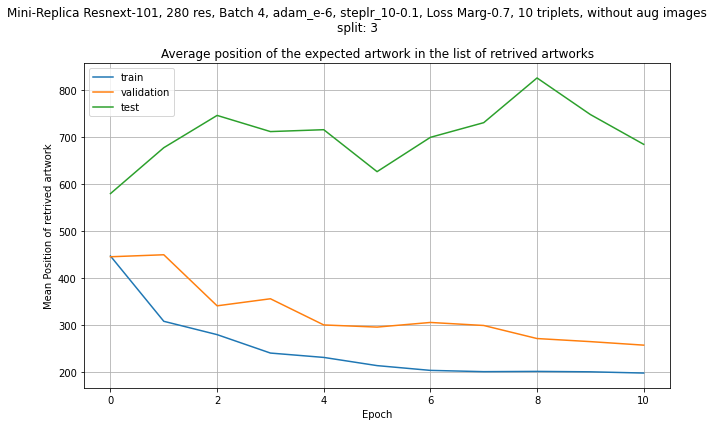

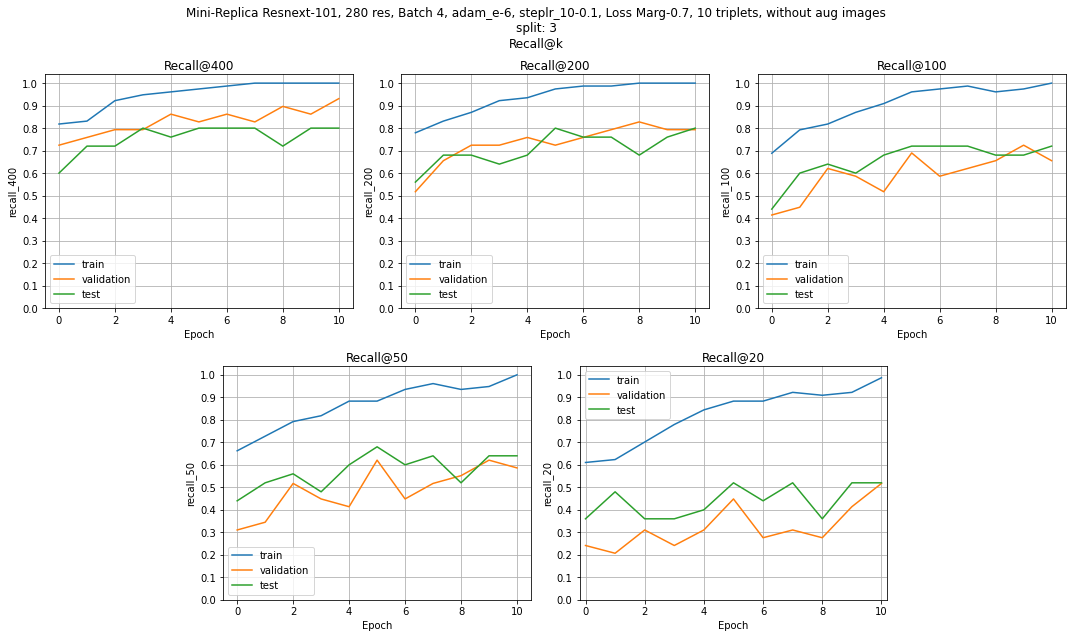

In [11]:
split_id = 3

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [12]:
best_epoch = 5

train_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v4

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,453.638554,482.493827,449.493827,0.372454,0.802469,0.753086,0.666667,0.641975,0.604938
1,360.349398,214.419753,307.148148,0.393266,0.851852,0.814815,0.753086,0.728395,0.629630
2,317.018072,148.530864,274.141975,0.484173,0.925926,0.888889,0.802469,0.790123,0.716049
3,297.240964,90.222222,245.086420,0.591549,0.925926,0.913580,0.851852,0.839506,0.765432
4,258.493976,37.703704,218.839506,0.671264,0.962963,0.938272,0.901235,0.901235,0.839506
5,242.283133,36.234568,218.141975,0.663020,0.950617,0.938272,0.925926,0.913580,0.827160
6,232.457831,12.395062,206.222222,0.783012,0.987654,0.950617,0.950617,0.925926,0.913580
7,216.921687,9.666667,204.858025,0.801423,0.987654,0.962963,0.950617,0.950617,0.913580
8,218.915663,5.901235,202.975309,0.866066,0.987654,0.975309,0.950617,0.950617,0.950617
9,213.391566,3.790123,201.919753,0.837938,0.987654,0.987654,0.975309,0.962963,0.950617


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,533.145161,674.166667,546.983333,0.100609,0.700000,0.500000,0.366667,0.266667,0.200000
1,335.000000,276.200000,339.600000,0.179011,0.866667,0.666667,0.600000,0.400000,0.266667
2,439.790323,505.766667,442.250000,0.163120,0.833333,0.733333,0.433333,0.400000,0.233333
3,351.903226,325.666667,350.866667,0.147557,0.866667,0.766667,0.633333,0.366667,0.233333
4,375.838710,376.133333,375.233333,0.208170,0.866667,0.700000,0.600000,0.400000,0.333333
5,380.790323,385.233333,380.650000,0.207521,0.833333,0.733333,0.700000,0.566667,0.333333
6,338.129032,297.000000,336.733333,0.206197,0.900000,0.733333,0.600000,0.466667,0.366667
7,339.274194,297.833333,338.383333,0.173449,0.866667,0.733333,0.500000,0.433333,0.300000
8,349.032258,319.400000,348.233333,0.228714,0.833333,0.766667,0.600000,0.500000,0.366667
9,336.435484,294.366667,334.783333,0.240428,0.900000,0.766667,0.600000,0.533333,0.400000


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,459.261905,426.550000,426.175000,0.363515,0.650000,0.650000,0.550000,0.550000,0.400000
1,586.238095,778.800000,601.800000,0.357306,0.650000,0.550000,0.500000,0.500000,0.450000
2,631.666667,886.000000,661.750000,0.308604,0.650000,0.600000,0.600000,0.500000,0.450000
3,595.952381,803.000000,621.100000,0.338808,0.700000,0.600000,0.550000,0.500000,0.500000
4,463.880952,550.150000,477.575000,0.364347,0.800000,0.650000,0.600000,0.550000,0.450000
5,519.547619,671.650000,529.775000,0.321654,0.750000,0.600000,0.500000,0.450000,0.450000
6,490.285714,598.500000,509.950000,0.407954,0.750000,0.650000,0.550000,0.500000,0.500000
7,479.023810,590.350000,490.175000,0.373184,0.750000,0.700000,0.550000,0.500000,0.500000
8,474.428571,581.800000,484.800000,0.317197,0.750000,0.700000,0.600000,0.600000,0.500000
9,450.428571,540.800000,454.800000,0.351562,0.850000,0.750000,0.650000,0.600000,0.500000


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,503.307692,575.120000,498.660000,0.205772,0.680000,0.560000,0.440000,0.380000,0.280000
1,436.461538,477.240000,444.480000,0.250329,0.780000,0.620000,0.560000,0.440000,0.340000
2,517.278846,657.860000,530.050000,0.221313,0.760000,0.680000,0.500000,0.440000,0.320000
3,450.461538,516.600000,458.960000,0.224057,0.800000,0.700000,0.600000,0.420000,0.340000
4,411.394231,445.740000,416.170000,0.270641,0.840000,0.680000,0.600000,0.460000,0.380000
5,436.826923,499.800000,440.300000,0.253174,0.800000,0.680000,0.620000,0.520000,0.380000
6,399.576923,417.600000,406.020000,0.286900,0.840000,0.700000,0.580000,0.480000,0.420000
7,395.711538,414.840000,399.100000,0.253343,0.820000,0.720000,0.520000,0.460000,0.380000
8,399.673077,424.360000,402.860000,0.264108,0.800000,0.740000,0.600000,0.540000,0.420000
9,382.471154,392.940000,382.790000,0.284882,0.880000,0.760000,0.620000,0.560000,0.440000


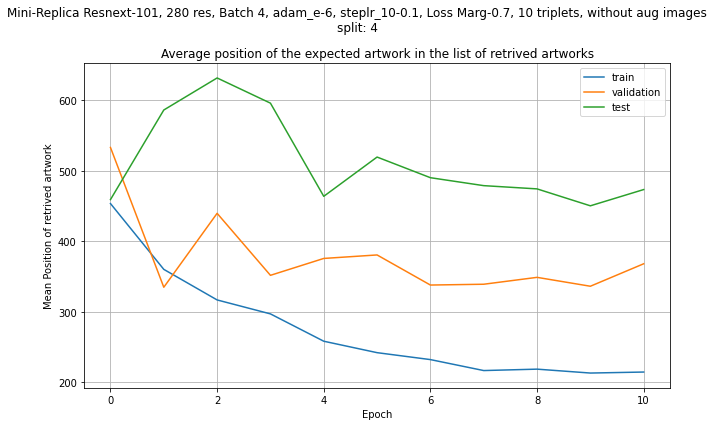

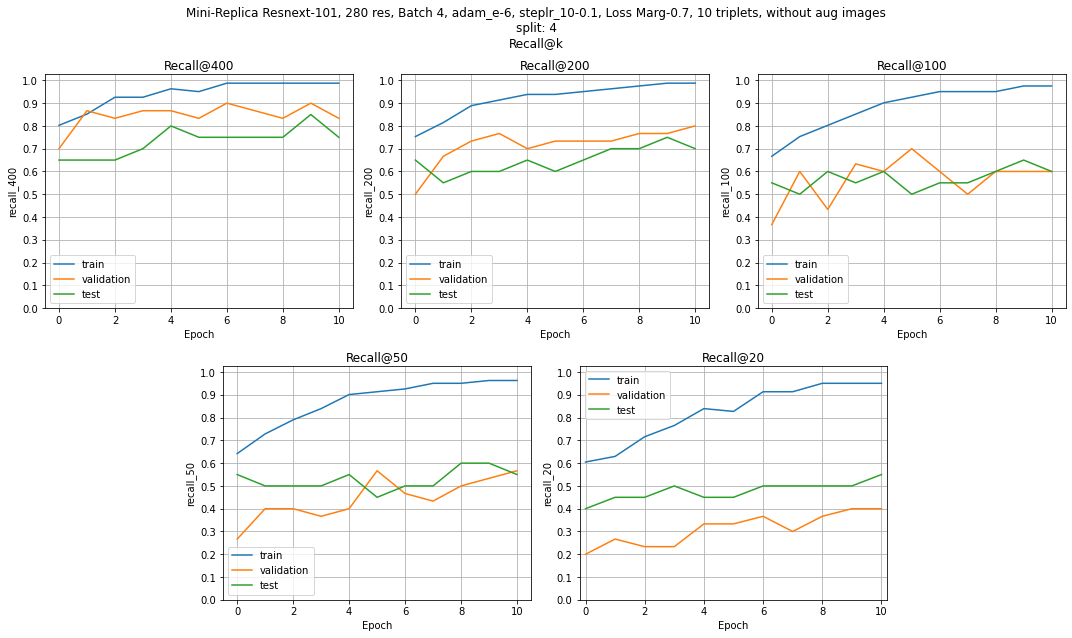

In [13]:
split_id = 4

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [14]:
best_epoch = 9

train_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v5

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,563.558140,688.578313,555.445783,0.321721,0.722892,0.674699,0.566265,0.542169,0.481928
1,428.209302,388.843373,395.987952,0.345163,0.807229,0.771084,0.698795,0.650602,0.542169
2,395.813953,316.819277,355.457831,0.437634,0.831325,0.795181,0.783133,0.710843,0.686747
3,336.273256,221.361446,306.765060,0.521635,0.867470,0.831325,0.807229,0.783133,0.710843
4,301.767442,165.590361,278.144578,0.614047,0.939759,0.879518,0.855422,0.855422,0.771084
5,274.470930,118.590361,254.692771,0.669918,0.951807,0.927711,0.891566,0.855422,0.795181
6,260.360465,106.771084,248.734940,0.700418,0.951807,0.951807,0.927711,0.915663,0.843373
7,213.982558,27.481928,208.993976,0.749734,0.963855,0.951807,0.939759,0.939759,0.915663
8,219.779070,47.469880,217.253012,0.829809,0.987952,0.975904,0.951807,0.951807,0.927711
9,202.046512,12.361446,198.060241,0.835928,0.987952,0.963855,0.951807,0.939759,0.927711


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,343.431034,286.862069,343.431034,0.318627,0.793103,0.586207,0.517241,0.413793,0.379310
1,459.879310,519.758621,459.879310,0.239558,0.827586,0.655172,0.586207,0.482759,0.344828
2,277.982759,155.965517,277.982759,0.313133,0.931034,0.793103,0.655172,0.482759,0.344828
3,276.827586,153.655172,276.827586,0.285009,0.862069,0.793103,0.689655,0.517241,0.413793
4,276.206897,152.413793,276.206897,0.288212,0.931034,0.793103,0.655172,0.551724,0.448276
5,236.913793,73.827586,236.913793,0.347220,0.965517,0.896552,0.793103,0.724138,0.551724
6,256.086207,112.172414,256.086207,0.347682,0.965517,0.896552,0.793103,0.655172,0.586207
7,236.258621,72.517241,236.258621,0.347080,0.965517,0.896552,0.793103,0.689655,0.620690
8,236.775862,73.551724,236.775862,0.364828,0.931034,0.931034,0.827586,0.758621,0.586207
9,238.258621,76.517241,238.258621,0.407743,0.931034,0.931034,0.862069,0.793103,0.689655


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,269.925000,124.578947,277.921053,0.237595,0.842105,0.842105,0.736842,0.736842,0.631579
1,266.275000,156.894737,259.447368,0.344101,0.842105,0.736842,0.736842,0.631579,0.473684
2,230.175000,82.578947,222.078947,0.362423,0.894737,0.842105,0.789474,0.736842,0.631579
3,265.150000,152.736842,260.684211,0.376149,0.947368,0.789474,0.736842,0.684211,0.578947
4,216.075000,50.368421,208.289474,0.354862,1.000000,0.894737,0.842105,0.789474,0.578947
5,235.350000,93.789474,227.263158,0.395529,0.947368,0.842105,0.842105,0.789474,0.684211
6,230.575000,83.000000,222.605263,0.353365,0.947368,0.842105,0.842105,0.736842,0.578947
7,236.375000,89.315789,230.973684,0.412641,0.894737,0.842105,0.842105,0.684211,0.631579
8,220.950000,61.789474,212.473684,0.382564,0.947368,0.894737,0.842105,0.789474,0.684211
9,223.100000,64.000000,215.736842,0.371021,0.947368,0.894737,0.842105,0.736842,0.631579


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,313.428571,222.625000,317.500000,0.286552,0.812500,0.687500,0.604167,0.541667,0.479167
1,380.857143,376.125000,380.541667,0.280940,0.833333,0.687500,0.645833,0.541667,0.395833
2,258.469388,126.916667,255.854167,0.332643,0.916667,0.812500,0.708333,0.583333,0.458333
3,272.061224,153.291667,270.437500,0.321086,0.895833,0.791667,0.708333,0.583333,0.479167
4,251.663265,112.020833,249.322917,0.314594,0.958333,0.833333,0.729167,0.645833,0.500000
5,236.275510,81.729167,233.093750,0.366342,0.958333,0.875000,0.812500,0.750000,0.604167
6,245.673469,100.625000,242.833333,0.349931,0.958333,0.875000,0.812500,0.687500,0.583333
7,236.306122,79.166667,234.166667,0.373031,0.937500,0.875000,0.812500,0.687500,0.625000
8,230.316327,68.895833,227.156250,0.371848,0.937500,0.916667,0.833333,0.770833,0.625000
9,232.071429,71.562500,229.343750,0.393207,0.937500,0.916667,0.854167,0.770833,0.666667


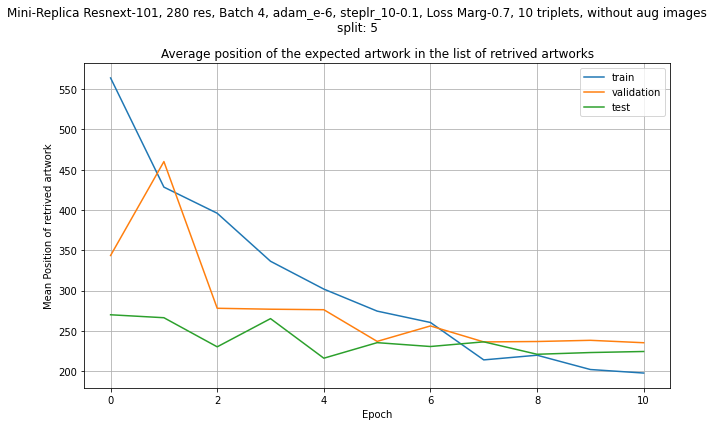

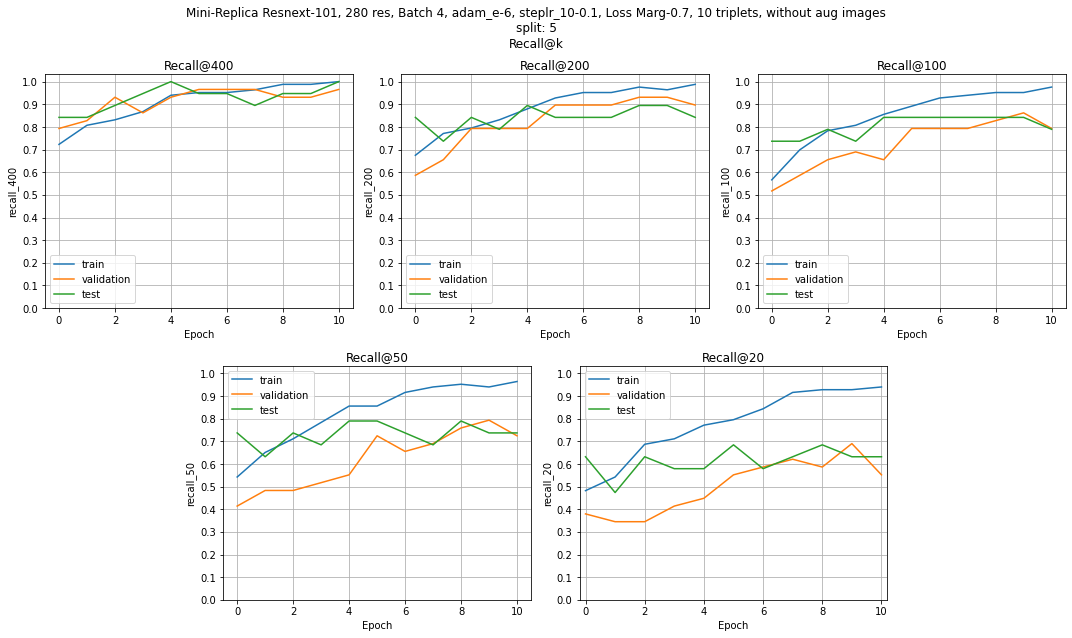

In [15]:
split_id = 5

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [16]:
best_epoch = 9

train_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v6

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,492.981707,565.762500,489.818750,0.313414,0.762500,0.725000,0.587500,0.575000,0.525000
1,409.865854,430.975000,412.775000,0.384523,0.825000,0.775000,0.700000,0.662500,0.587500
2,313.963415,241.000000,312.962500,0.444063,0.900000,0.850000,0.825000,0.762500,0.687500
3,298.457317,210.087500,296.756250,0.579945,0.925000,0.900000,0.862500,0.825000,0.762500
4,271.237805,155.787500,268.081250,0.589954,0.937500,0.912500,0.912500,0.825000,0.775000
5,257.664634,128.012500,254.181250,0.702594,0.975000,0.950000,0.912500,0.912500,0.875000
6,242.036585,96.050000,238.137500,0.768827,0.975000,0.950000,0.950000,0.937500,0.912500
7,208.737805,27.787500,204.018750,0.773910,0.987500,0.975000,0.937500,0.937500,0.900000
8,196.762195,3.312500,191.706250,0.850669,1.000000,1.000000,1.000000,0.975000,0.950000
9,204.134146,18.375000,199.275000,0.854975,0.987500,0.987500,0.987500,0.950000,0.937500


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,459.275000,408.277778,441.250000,0.349464,0.722222,0.722222,0.722222,0.666667,0.500000
1,571.975000,253.722222,325.361111,0.270516,0.833333,0.666667,0.666667,0.611111,0.388889
2,493.000000,137.888889,262.333333,0.260219,0.888889,0.722222,0.611111,0.611111,0.444444
3,486.125000,177.944444,286.027778,0.296208,0.833333,0.666667,0.666667,0.555556,0.444444
4,529.250000,154.000000,274.666667,0.321454,0.833333,0.722222,0.722222,0.611111,0.388889
5,476.600000,108.000000,248.388889,0.302667,0.833333,0.777778,0.611111,0.611111,0.555556
6,512.075000,153.500000,274.027778,0.297170,0.833333,0.722222,0.722222,0.555556,0.500000
7,461.275000,153.722222,275.861111,0.323274,0.833333,0.833333,0.722222,0.722222,0.500000
8,442.225000,134.833333,265.416667,0.341968,0.833333,0.722222,0.666667,0.611111,0.388889
9,469.450000,93.888889,246.388889,0.309358,0.888889,0.777778,0.722222,0.722222,0.555556


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,430.727273,461.454545,430.727273,0.275573,0.757576,0.545455,0.484848,0.393939,0.363636
1,363.075758,326.151515,363.075758,0.206856,0.818182,0.696970,0.606061,0.454545,0.363636
2,389.015152,378.030303,389.015152,0.234716,0.757576,0.636364,0.545455,0.454545,0.363636
3,401.196970,402.393939,401.196970,0.242915,0.787879,0.666667,0.575758,0.515152,0.424242
4,346.636364,293.272727,346.636364,0.222868,0.757576,0.727273,0.606061,0.454545,0.363636
5,358.409091,316.818182,358.409091,0.227668,0.757576,0.727273,0.636364,0.545455,0.424242
6,333.257576,266.515152,333.257576,0.209761,0.848485,0.727273,0.666667,0.515152,0.393939
7,378.484848,356.969697,378.484848,0.237456,0.727273,0.636364,0.515152,0.393939,0.303030
8,357.651515,315.303030,357.651515,0.274033,0.787879,0.757576,0.606061,0.515152,0.393939
9,326.818182,253.636364,326.818182,0.229144,0.878788,0.757576,0.666667,0.515152,0.393939


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,441.500000,442.686275,434.441176,0.301653,0.745098,0.607843,0.568627,0.490196,0.411765
1,441.905660,300.588235,349.764706,0.229325,0.823529,0.686275,0.627451,0.509804,0.372549
2,428.254717,293.274510,344.303922,0.243717,0.803922,0.666667,0.568627,0.509804,0.392157
3,433.245283,323.176471,360.549020,0.261724,0.803922,0.666667,0.607843,0.529412,0.431373
4,415.547170,244.117647,321.235294,0.257663,0.784314,0.725490,0.647059,0.509804,0.372549
5,403.009434,243.117647,319.578431,0.254138,0.784314,0.745098,0.627451,0.568627,0.470588
6,400.735849,226.627451,312.352941,0.240611,0.843137,0.725490,0.686275,0.529412,0.431373
7,409.726415,285.235294,342.264706,0.267745,0.764706,0.705882,0.588235,0.509804,0.372549
8,389.566038,251.607843,325.098039,0.298010,0.803922,0.745098,0.627451,0.549020,0.392157
9,380.641509,197.254902,298.431373,0.257455,0.882353,0.764706,0.686275,0.588235,0.450980


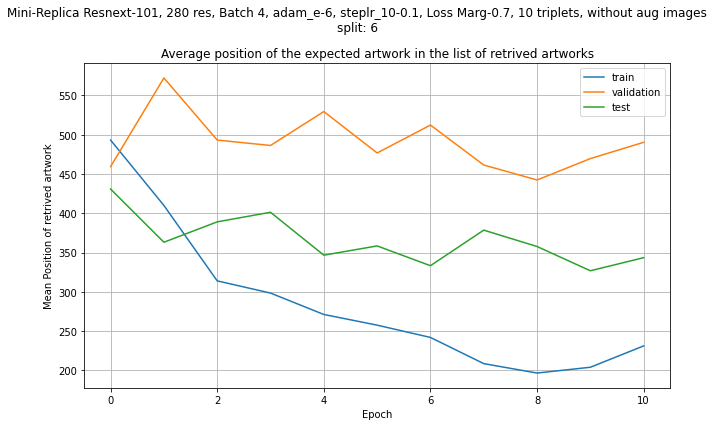

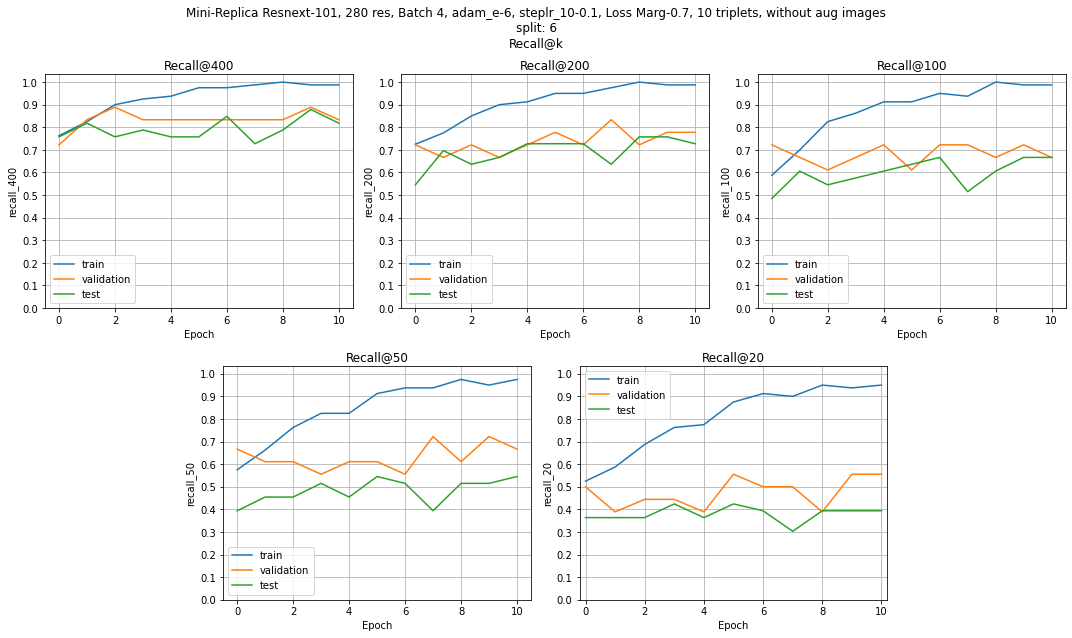

In [17]:
split_id = 6

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [18]:
best_epoch = 9

train_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v7

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,345.452632,267.182796,339.559140,0.290209,0.795699,0.720430,0.602151,0.548387,0.483871
1,285.763158,169.043011,287.252688,0.432085,0.870968,0.817204,0.763441,0.709677,0.645161
2,249.815789,107.817204,247.844086,0.529702,0.935484,0.903226,0.860215,0.806452,0.752688
3,220.373684,48.655914,217.241935,0.625393,0.967742,0.913978,0.903226,0.881720,0.806452
4,221.363158,51.666667,217.811828,0.687465,0.967742,0.956989,0.924731,0.913978,0.881720
5,204.205263,17.043011,200.048387,0.711371,0.989247,0.956989,0.946237,0.935484,0.892473
6,199.094737,6.559140,194.860215,0.796449,1.000000,1.000000,0.978495,0.956989,0.924731
7,198.378947,4.903226,194.236559,0.858255,1.000000,1.000000,0.978495,0.956989,0.946237
8,197.042105,2.451613,192.731183,0.871098,1.000000,1.000000,1.000000,0.978495,0.946237
9,196.484211,1.354839,192.139785,0.883578,1.000000,1.000000,1.000000,1.000000,0.956989


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,835.500000,1271.000000,835.500000,0.280698,0.684211,0.631579,0.526316,0.526316,0.473684
1,905.000000,1410.000000,905.000000,0.205478,0.684211,0.684211,0.578947,0.473684,0.421053
2,803.763158,1207.526316,803.763158,0.188697,0.736842,0.736842,0.526316,0.526316,0.421053
3,854.473684,1308.947368,854.473684,0.174062,0.736842,0.578947,0.473684,0.473684,0.368421
4,776.131579,1152.263158,776.131579,0.188258,0.736842,0.684211,0.684211,0.526316,0.421053
5,752.236842,1104.473684,752.236842,0.256769,0.684211,0.578947,0.526316,0.526316,0.473684
6,747.815789,1095.631579,747.815789,0.289739,0.789474,0.631579,0.526316,0.526316,0.473684
7,821.421053,1242.842105,821.421053,0.271726,0.684211,0.578947,0.526316,0.526316,0.421053
8,648.184211,896.368421,648.184211,0.221124,0.736842,0.631579,0.473684,0.473684,0.473684
9,701.447368,1002.894737,701.447368,0.258602,0.684211,0.631579,0.526316,0.526316,0.473684


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,720.547619,991.631579,730.973684,0.428138,0.631579,0.526316,0.526316,0.526316,0.473684
1,474.904762,374.736842,382.894737,0.423185,0.684211,0.684211,0.526316,0.473684,0.473684
2,558.000000,220.210526,307.157895,0.422076,0.736842,0.684211,0.631579,0.578947,0.526316
3,564.238095,258.526316,327.947368,0.403157,0.736842,0.684211,0.631579,0.631579,0.526316
4,600.738095,344.368421,371.500000,0.450149,0.684211,0.684211,0.684211,0.631579,0.631579
5,564.666667,308.421053,354.210526,0.449482,0.736842,0.684211,0.631579,0.631579,0.578947
6,489.952381,146.421053,272.842105,0.462063,0.842105,0.736842,0.684211,0.631579,0.578947
7,480.809524,210.105263,304.368421,0.388775,0.789474,0.684211,0.684211,0.631579,0.578947
8,537.714286,252.210526,325.684211,0.444303,0.736842,0.736842,0.684211,0.578947,0.578947
9,557.476190,263.052632,330.894737,0.439821,0.736842,0.684211,0.684211,0.684211,0.578947


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,775.150000,1131.315789,783.236842,0.354418,0.657895,0.578947,0.526316,0.526316,0.473684
1,679.200000,892.368421,643.947368,0.314332,0.684211,0.684211,0.552632,0.473684,0.447368
2,674.737500,713.868421,555.460526,0.305386,0.736842,0.710526,0.578947,0.552632,0.473684
3,702.100000,783.736842,591.210526,0.288609,0.736842,0.631579,0.552632,0.552632,0.447368
4,684.050000,748.315789,573.815789,0.319204,0.710526,0.684211,0.684211,0.578947,0.526316
5,653.762500,706.447368,553.223684,0.353126,0.710526,0.631579,0.578947,0.578947,0.526316
6,612.437500,621.026316,510.328947,0.375901,0.815789,0.684211,0.605263,0.578947,0.526316
7,642.600000,726.473684,562.894737,0.330251,0.736842,0.631579,0.605263,0.578947,0.500000
8,590.187500,574.289474,486.934211,0.332714,0.736842,0.684211,0.578947,0.526316,0.526316
9,625.862500,632.973684,516.171053,0.349211,0.710526,0.657895,0.605263,0.605263,0.526316


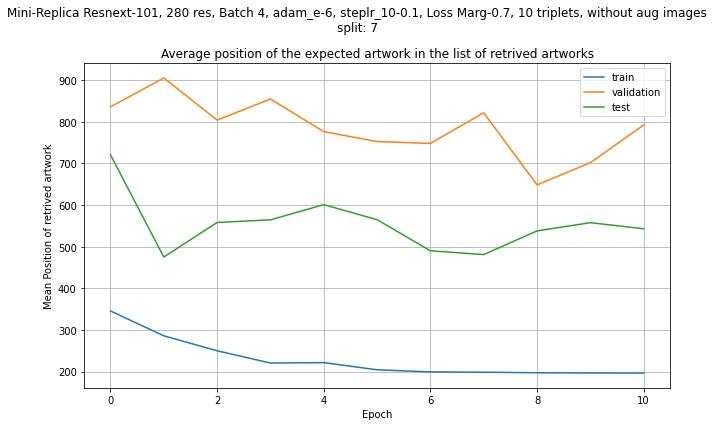

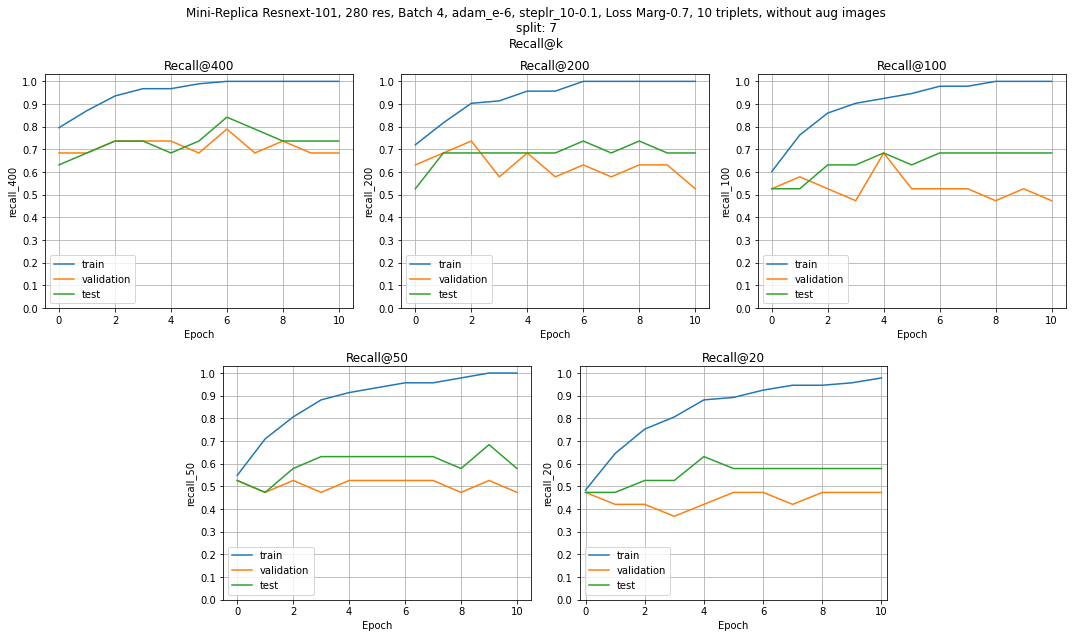

In [19]:
split_id = 7

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [20]:
best_epoch = 6

train_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v8

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,477.395349,546.048193,474.915663,0.351342,0.783133,0.734940,0.602410,0.590361,0.518072
1,355.779070,329.638554,356.963855,0.392218,0.831325,0.783133,0.734940,0.662651,0.602410
2,261.116279,139.783133,256.686747,0.484009,0.903614,0.855422,0.807229,0.759036,0.698795
3,227.726744,71.457831,221.680723,0.533902,0.951807,0.903614,0.855422,0.807229,0.746988
4,218.366279,52.132530,211.957831,0.608970,0.963855,0.891566,0.879518,0.855422,0.795181
5,208.232558,31.421687,201.349398,0.732339,0.963855,0.951807,0.927711,0.903614,0.843373
6,206.720930,28.240964,199.807229,0.774486,0.987952,0.975904,0.963855,0.939759,0.903614
7,196.529070,7.144578,189.234940,0.828954,1.000000,0.987952,0.975904,0.963855,0.951807
8,194.546512,3.036145,187.180723,0.851740,1.000000,1.000000,1.000000,0.975904,0.963855
9,195.569767,5.180723,188.228916,0.900524,1.000000,0.987952,0.987952,0.987952,0.987952


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,538.451613,585.466667,528.266667,0.160621,0.633333,0.433333,0.400000,0.300000,0.266667
1,630.677419,511.533333,467.800000,0.171428,0.800000,0.733333,0.466667,0.366667,0.266667
2,666.403226,546.700000,485.750000,0.213429,0.733333,0.700000,0.600000,0.433333,0.266667
3,668.209677,524.633333,474.383333,0.167801,0.800000,0.666667,0.533333,0.333333,0.233333
4,590.290323,543.333333,484.666667,0.184039,0.766667,0.666667,0.666667,0.533333,0.366667
5,612.274194,486.766667,455.450000,0.181967,0.800000,0.733333,0.566667,0.400000,0.300000
6,646.225806,514.133333,466.800000,0.163928,0.833333,0.766667,0.600000,0.466667,0.400000
7,636.387097,523.533333,474.100000,0.178513,0.800000,0.700000,0.600000,0.466667,0.300000
8,651.806452,572.333333,498.466667,0.173508,0.800000,0.700000,0.566667,0.466667,0.333333
9,624.677419,469.133333,446.233333,0.160962,0.866667,0.800000,0.633333,0.533333,0.433333


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,337.555556,275.111111,337.555556,0.359856,0.833333,0.833333,0.777778,0.722222,0.666667
1,356.111111,312.222222,356.111111,0.299470,0.888889,0.833333,0.666667,0.666667,0.555556
2,311.611111,223.222222,311.611111,0.346398,0.888889,0.833333,0.722222,0.722222,0.555556
3,324.277778,248.555556,324.277778,0.328884,0.888889,0.777778,0.722222,0.666667,0.444444
4,345.583333,291.166667,345.583333,0.326571,0.777778,0.722222,0.722222,0.722222,0.444444
5,326.500000,253.000000,326.500000,0.337068,0.888889,0.833333,0.722222,0.722222,0.555556
6,325.916667,251.833333,325.916667,0.431489,0.888889,0.777778,0.777778,0.722222,0.611111
7,346.833333,293.666667,346.833333,0.322443,0.888889,0.833333,0.722222,0.722222,0.666667
8,306.388889,212.777778,306.388889,0.393544,0.888889,0.777778,0.722222,0.722222,0.666667
9,314.666667,229.333333,314.666667,0.441908,0.833333,0.833333,0.722222,0.722222,0.722222


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,464.653061,469.083333,456.750000,0.235334,0.708333,0.583333,0.541667,0.458333,0.416667
1,529.816327,436.791667,425.916667,0.219444,0.833333,0.770833,0.541667,0.479167,0.375000
2,536.071429,425.395833,420.447917,0.263293,0.791667,0.750000,0.645833,0.541667,0.375000
3,541.867347,421.104167,418.093750,0.228207,0.833333,0.708333,0.604167,0.458333,0.312500
4,500.397959,448.770833,432.510417,0.237488,0.770833,0.687500,0.687500,0.604167,0.395833
5,507.295918,399.104167,407.093750,0.240130,0.833333,0.770833,0.625000,0.520833,0.395833
6,528.561224,415.770833,413.968750,0.264263,0.854167,0.770833,0.666667,0.562500,0.479167
7,530.020408,437.333333,426.375000,0.232487,0.833333,0.750000,0.645833,0.562500,0.437500
8,524.918367,437.500000,426.437500,0.256021,0.833333,0.729167,0.625000,0.562500,0.458333
9,510.795918,379.208333,396.895833,0.266317,0.854167,0.812500,0.666667,0.604167,0.541667


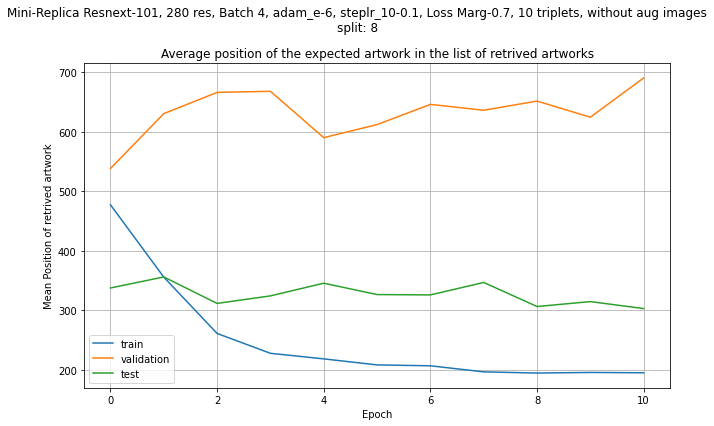

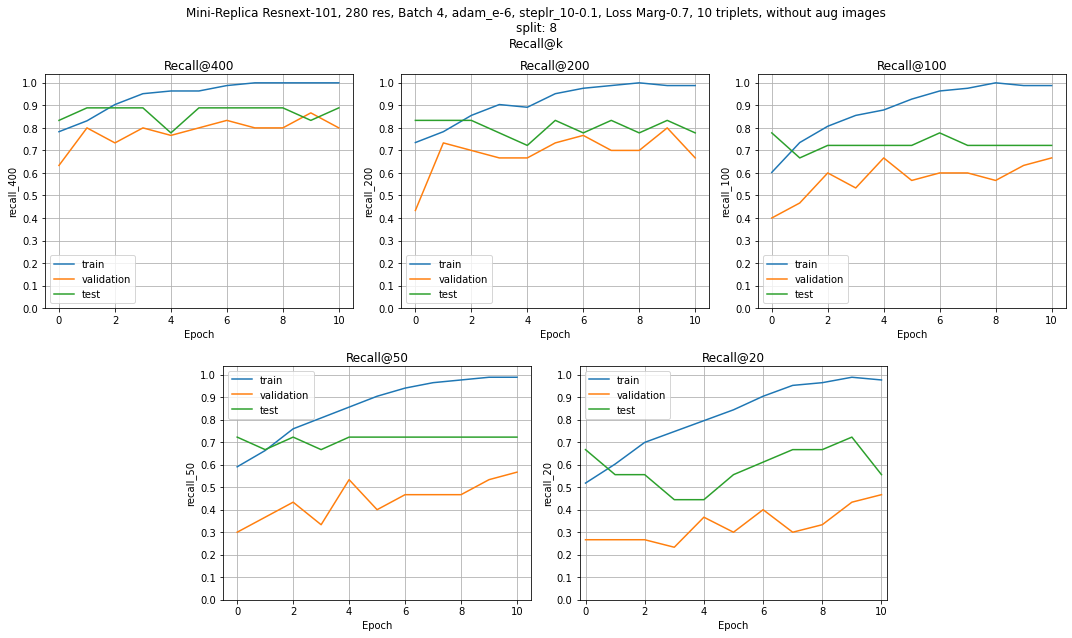

In [21]:
split_id = 8

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [22]:
best_epoch = 9

train_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v9

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,514.330000,594.333333,509.906250,0.255502,0.729167,0.656250,0.552083,0.510417,0.447917
1,395.720000,317.812500,354.468750,0.337283,0.843750,0.791667,0.729167,0.645833,0.562500
2,329.000000,232.583333,310.375000,0.475184,0.843750,0.822917,0.791667,0.750000,0.697917
3,291.015000,133.385417,261.098958,0.578694,0.885417,0.854167,0.833333,0.822917,0.781250
4,263.670000,99.625000,242.000000,0.654201,0.916667,0.895833,0.875000,0.864583,0.812500
5,239.200000,57.729167,220.739583,0.712817,0.968750,0.937500,0.906250,0.854167,0.843750
6,217.780000,37.979167,211.072917,0.723531,0.979167,0.979167,0.937500,0.937500,0.875000
7,218.475000,26.843750,205.171875,0.808335,0.979167,0.979167,0.968750,0.927083,0.906250
8,201.680000,3.729167,193.593750,0.854218,0.989583,0.989583,0.979167,0.968750,0.927083
9,205.075000,5.697917,194.578125,0.855281,0.989583,0.979167,0.979167,0.968750,0.937500


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,433.500000,467.000000,433.500000,0.423316,0.789474,0.736842,0.578947,0.526316,0.526316
1,372.921053,345.842105,372.921053,0.417065,0.736842,0.684211,0.578947,0.526316,0.526316
2,351.815789,303.631579,351.815789,0.402710,0.789474,0.684211,0.631579,0.631579,0.526316
3,371.657895,343.315789,371.657895,0.387949,0.789474,0.736842,0.631579,0.631579,0.578947
4,262.789474,125.578947,262.789474,0.460200,0.842105,0.789474,0.736842,0.526316,0.526316
5,296.684211,193.368421,296.684211,0.484448,0.842105,0.736842,0.684211,0.578947,0.526316
6,301.526316,203.052632,301.526316,0.438423,0.789474,0.631579,0.631579,0.631579,0.526316
7,297.157895,194.315789,297.157895,0.483835,0.894737,0.789474,0.684211,0.578947,0.526316
8,267.473684,134.947368,267.473684,0.441859,0.894737,0.842105,0.684211,0.631579,0.578947
9,291.000000,182.000000,291.000000,0.424394,0.894737,0.789474,0.684211,0.631579,0.578947


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,259.656250,119.312500,259.656250,0.492885,0.875000,0.750000,0.750000,0.750000,0.625000
1,230.500000,61.000000,230.500000,0.573708,0.937500,0.875000,0.812500,0.750000,0.687500
2,227.875000,55.750000,227.875000,0.531713,0.937500,0.875000,0.875000,0.812500,0.687500
3,229.937500,59.875000,229.937500,0.483471,0.937500,0.937500,0.812500,0.750000,0.687500
4,214.750000,29.500000,214.750000,0.443345,1.000000,0.937500,0.937500,0.750000,0.687500
5,221.375000,42.750000,221.375000,0.457732,1.000000,0.937500,0.812500,0.750000,0.687500
6,224.781250,49.562500,224.781250,0.488833,1.000000,0.937500,0.750000,0.687500,0.625000
7,218.656250,37.312500,218.656250,0.477252,1.000000,1.000000,0.875000,0.750000,0.687500
8,222.656250,45.312500,222.656250,0.471802,0.937500,0.937500,0.875000,0.750000,0.687500
9,218.031250,36.062500,218.031250,0.484052,1.000000,1.000000,0.875000,0.687500,0.625000


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,354.028571,308.057143,354.028571,0.455119,0.828571,0.742857,0.657143,0.628571,0.571429
1,307.814286,215.628571,307.814286,0.488673,0.828571,0.771429,0.685714,0.628571,0.600000
2,295.157143,190.314286,295.157143,0.461683,0.857143,0.771429,0.742857,0.714286,0.600000
3,306.871429,213.742857,306.871429,0.431616,0.857143,0.828571,0.714286,0.685714,0.628571
4,240.828571,81.657143,240.828571,0.452495,0.914286,0.857143,0.828571,0.628571,0.600000
5,262.257143,124.514286,262.257143,0.472235,0.914286,0.828571,0.742857,0.657143,0.600000
6,266.442857,132.885714,266.442857,0.461467,0.885714,0.771429,0.685714,0.657143,0.571429
7,261.271429,122.542857,261.271429,0.480825,0.942857,0.885714,0.771429,0.657143,0.600000
8,246.985714,93.971429,246.985714,0.455547,0.914286,0.885714,0.771429,0.685714,0.628571
9,257.642857,115.285714,257.642857,0.451666,0.942857,0.885714,0.771429,0.657143,0.600000


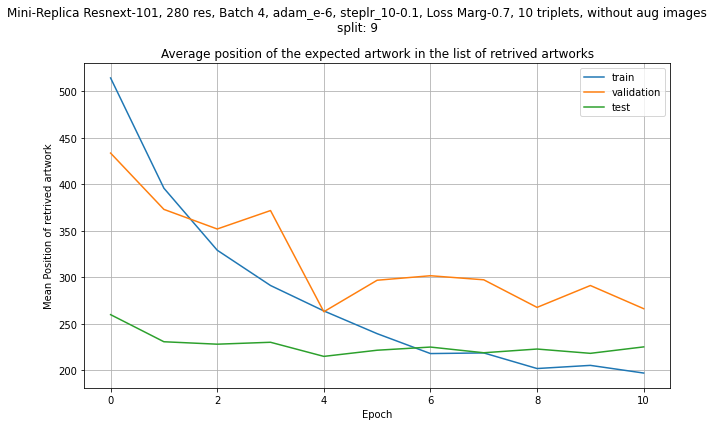

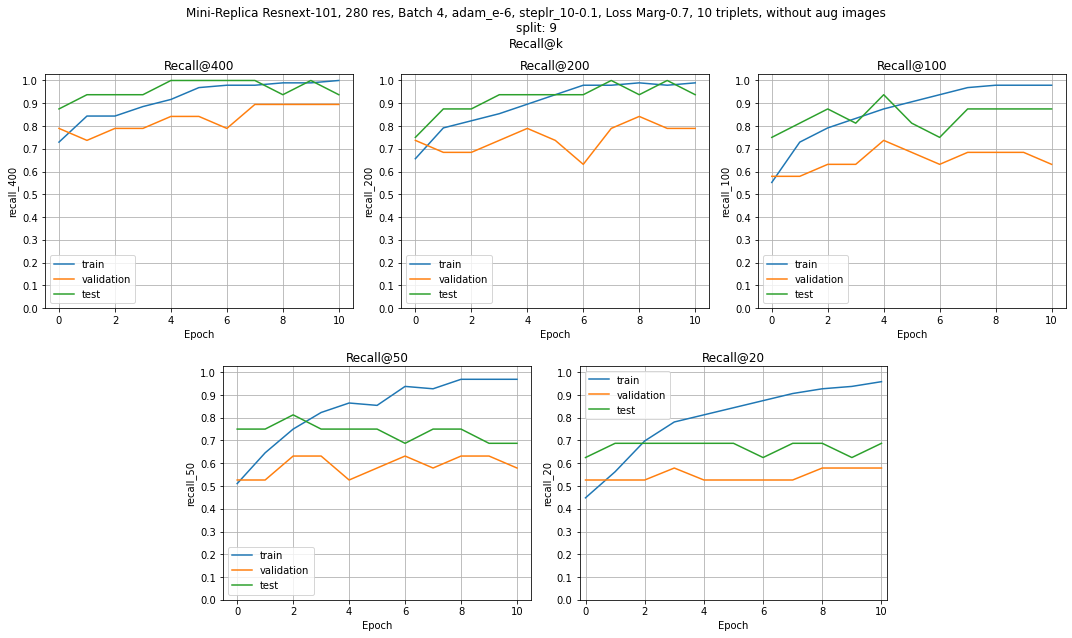

In [23]:
split_id = 9

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [24]:
best_epoch = 4

train_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v10

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,462.200000,473.548387,451.010753,0.275396,0.752688,0.645161,0.559140,0.516129,0.473118
1,354.826316,226.376344,313.876344,0.360342,0.849462,0.827957,0.763441,0.709677,0.623656
2,310.931579,147.580645,275.134409,0.494114,0.892473,0.870968,0.827957,0.774194,0.709677
3,289.705263,68.021505,234.086022,0.614341,0.924731,0.903226,0.870968,0.849462,0.795699
4,247.152632,34.741935,217.413978,0.638621,0.956989,0.946237,0.903226,0.860215,0.827957
5,230.784211,19.236559,209.661290,0.734545,0.978495,0.956989,0.946237,0.935484,0.881720
6,232.557895,7.655914,203.870968,0.798108,0.989247,0.978495,0.978495,0.956989,0.913978
7,218.910526,4.741935,202.456989,0.842359,0.989247,0.978495,0.978495,0.978495,0.924731
8,204.836842,3.258065,201.650538,0.856021,0.989247,0.989247,0.989247,0.967742,0.935484
9,214.947368,1.290323,200.666667,0.898785,0.989247,0.989247,0.989247,0.989247,0.956989


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,558.520833,780.772727,585.795455,0.431117,0.727273,0.727273,0.590909,0.590909,0.500000
1,461.687500,602.863636,469.113636,0.373170,0.818182,0.818182,0.727273,0.636364,0.545455
2,448.916667,574.363636,455.500000,0.376706,0.818182,0.818182,0.727273,0.590909,0.545455
3,407.750000,489.000000,408.681818,0.430006,0.863636,0.818182,0.772727,0.727273,0.590909
4,365.104167,392.500000,362.159091,0.435372,0.818182,0.772727,0.727273,0.681818,0.500000
5,405.395833,480.318182,407.113636,0.403038,0.818182,0.772727,0.636364,0.636364,0.545455
6,393.729167,456.045455,394.340909,0.475891,0.863636,0.818182,0.727273,0.681818,0.545455
7,402.270833,475.863636,403.295455,0.496796,0.863636,0.772727,0.727273,0.727273,0.681818
8,412.812500,496.863636,415.704545,0.486937,0.863636,0.772727,0.727273,0.727273,0.636364
9,342.520833,346.045455,337.750000,0.452872,0.863636,0.818182,0.772727,0.681818,0.590909


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,406.906250,413.812500,406.906250,0.335062,0.812500,0.812500,0.687500,0.625000,0.500000
1,522.093750,644.187500,522.093750,0.339519,0.750000,0.750000,0.625000,0.500000,0.500000
2,537.687500,675.375000,537.687500,0.387768,0.750000,0.687500,0.625000,0.500000,0.500000
3,518.718750,637.437500,518.718750,0.376913,0.875000,0.812500,0.687500,0.687500,0.500000
4,514.437500,628.875000,514.437500,0.360481,0.812500,0.687500,0.687500,0.625000,0.562500
5,526.156250,652.312500,526.156250,0.342145,0.812500,0.750000,0.687500,0.562500,0.500000
6,523.437500,646.875000,523.437500,0.325106,0.812500,0.812500,0.625000,0.562500,0.437500
7,456.500000,513.000000,456.500000,0.402380,0.875000,0.875000,0.750000,0.625000,0.562500
8,516.468750,632.937500,516.468750,0.432372,0.812500,0.812500,0.812500,0.625000,0.500000
9,458.062500,516.125000,458.062500,0.388079,0.875000,0.875000,0.750000,0.687500,0.562500


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,497.875000,626.263158,510.473684,0.390673,0.763158,0.763158,0.631579,0.605263,0.500000
1,485.850000,620.263158,491.421053,0.359001,0.789474,0.789474,0.684211,0.578947,0.526316
2,484.425000,616.894737,490.105263,0.381364,0.789474,0.763158,0.684211,0.552632,0.526316
3,452.137500,551.500000,455.013158,0.407651,0.868421,0.815789,0.736842,0.710526,0.552632
4,424.837500,492.026316,426.276316,0.403839,0.815789,0.736842,0.710526,0.657895,0.526316
5,453.700000,552.736842,457.236842,0.377399,0.815789,0.763158,0.657895,0.605263,0.526316
6,445.612500,536.394737,448.697368,0.412402,0.842105,0.815789,0.684211,0.631579,0.500000
7,423.962500,491.500000,425.697368,0.457042,0.868421,0.815789,0.736842,0.684211,0.631579
8,454.275000,554.157895,458.131579,0.463962,0.842105,0.789474,0.763158,0.684211,0.578947
9,388.737500,417.657895,388.407895,0.425591,0.868421,0.842105,0.763158,0.684211,0.578947


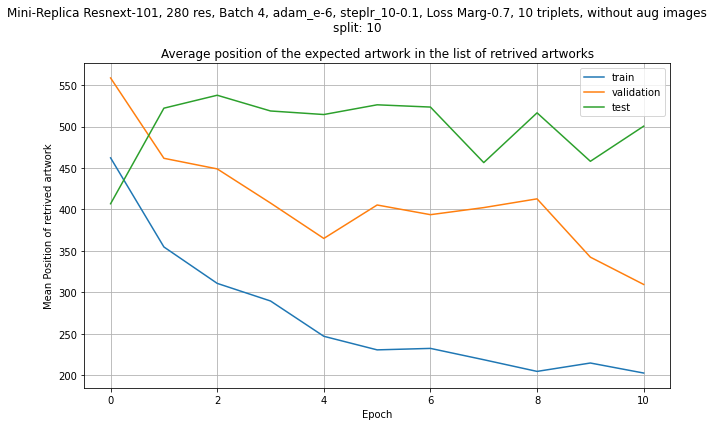

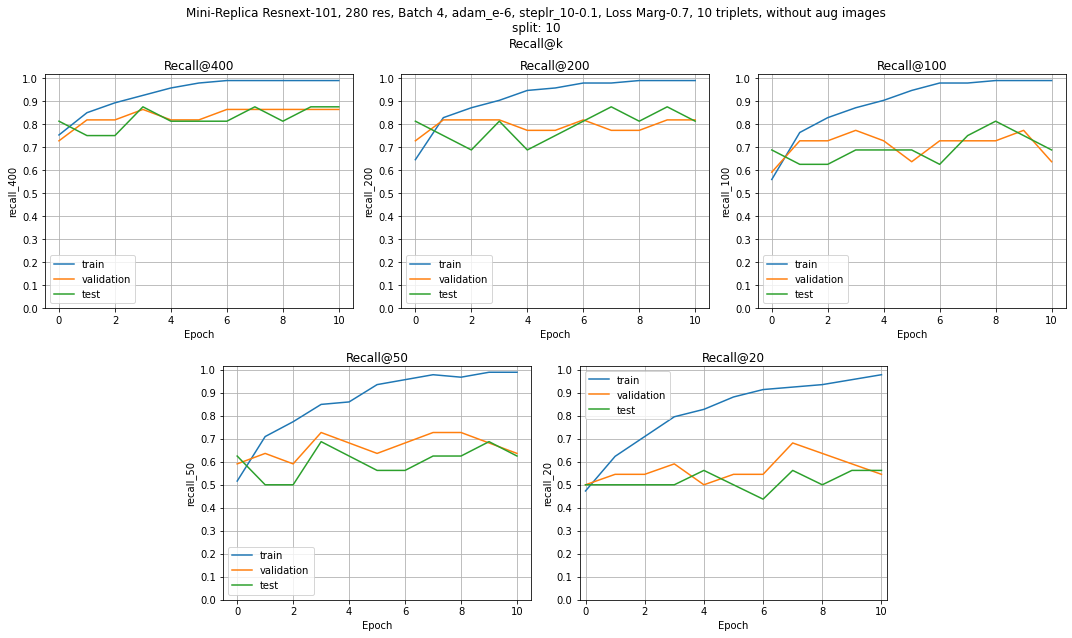

In [25]:
split_id = 10

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [26]:
best_epoch = 7

train_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug Mini-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

In [27]:
train_metrics_df = pd.DataFrame(train_metrics, columns=["model", "data_split_version", "best_epoch", "MP","MMP", "mean_median_position", 'MAP','R@400', 'R@200', 'R@100', 'R@50', 'R@20'])
val_metrics_df = pd.DataFrame(val_metrics, columns=["model", "data_split_version", "best_epoch", "MP","MMP", "mean_median_position", 'MAP','R@400', 'R@200', 'R@100', 'R@50', 'R@20'])
test_metrics_df = pd.DataFrame(test_metrics, columns=["model", "data_split_version", "best_epoch", "MP","MMP", "mean_median_position", 'MAP','R@400', 'R@200', 'R@100', 'R@50', 'R@20'])
non_train_metrics_df = pd.DataFrame(non_train_metrics, columns=["model", "data_split_version", "best_epoch", "MP","MMP", "mean_median_position", 'MAP','R@400', 'R@200', 'R@100', 'R@50', 'R@20'])

In [28]:
train_metrics_df["MAP"] = 100 * train_metrics_df["MAP"]
train_metrics_df["R@400"] = 100 * train_metrics_df["R@400"]
train_metrics_df["R@200"] = 100 * train_metrics_df["R@200"]
train_metrics_df["R@100"] = 100 * train_metrics_df["R@100"]
train_metrics_df["R@50"] = 100 * train_metrics_df["R@50"]
train_metrics_df["R@20"] = 100 * train_metrics_df["R@20"]

val_metrics_df["MAP"] = 100 * val_metrics_df["MAP"]
val_metrics_df["R@400"] = 100 * val_metrics_df["R@400"]
val_metrics_df["R@200"] = 100 * val_metrics_df["R@200"]
val_metrics_df["R@100"] = 100 * val_metrics_df["R@100"]
val_metrics_df["R@50"] = 100 * val_metrics_df["R@50"]
val_metrics_df["R@20"] = 100 * val_metrics_df["R@20"]

test_metrics_df["MAP"] = 100 * test_metrics_df["MAP"]
test_metrics_df["R@400"] = 100 * test_metrics_df["R@400"]
test_metrics_df["R@200"] = 100 * test_metrics_df["R@200"]
test_metrics_df["R@100"] = 100 * test_metrics_df["R@100"]
test_metrics_df["R@50"] = 100 * test_metrics_df["R@50"]
test_metrics_df["R@20"] = 100 * test_metrics_df["R@20"]

non_train_metrics_df["MAP"] = 100 * non_train_metrics_df["MAP"]
non_train_metrics_df["R@400"] = 100 * non_train_metrics_df["R@400"]
non_train_metrics_df["R@200"] = 100 * non_train_metrics_df["R@200"]
non_train_metrics_df["R@100"] = 100 * non_train_metrics_df["R@100"]
non_train_metrics_df["R@50"] = 100 * non_train_metrics_df["R@50"]
non_train_metrics_df["R@20"] = 100 * non_train_metrics_df["R@20"]

In [29]:
train_metrics_df

,model,data_split_version,best_epoch,MP,MMP,mean_median_position,MAP,R@400,R@200,R@100,R@50,R@20
0,FT No-Aug Mini-Replica,0,6,216.910526,14.440860,207.284946,74.562735,97.849462,95.698925,95.698925,93.548387,91.397849
1,FT No-Aug Mini-Replica,1,8,225.898810,11.812500,196.006250,81.940567,97.500000,97.500000,95.000000,93.750000,93.750000
2,FT No-Aug Mini-Replica,2,9,202.305882,7.146341,198.731707,83.902851,97.560976,97.560976,96.341463,96.341463,95.121951
3,FT No-Aug Mini-Replica,3,5,213.839744,33.207792,211.435065,72.953923,97.402597,97.402597,96.103896,88.311688,88.311688
4,FT No-Aug Mini-Replica,4,9,213.391566,3.790123,201.919753,83.793841,98.765432,98.765432,97.530864,96.296296,95.061728
5,FT No-Aug Mini-Replica,5,9,202.046512,12.361446,198.060241,83.592806,98.795181,96.385542,95.180723,93.975904,92.771084
6,FT No-Aug Mini-Replica,6,9,204.134146,18.375000,199.275000,85.497529,98.750000,98.750000,98.750000,95.000000,93.750000
7,FT No-Aug Mini-Replica,7,6,199.094737,6.559140,194.860215,79.644874,100.000000,100.000000,97.849462,95.698925,92.473118
8,FT No-Aug Mini-Replica,8,9,195.569767,5.180723,188.228916,90.052426,100.000000,98.795181,98.795181,98.795181,98.795181
9,FT No-Aug Mini-Replica,9,4,263.670000,99.625000,242.000000,65.420053,91.666667,89.583333,87.500000,86.458333,81.250000


In [30]:
val_metrics_df

,model,data_split_version,best_epoch,MP,MMP,mean_median_position,MAP,R@400,R@200,R@100,R@50,R@20
0,FT No-Aug Mini-Replica,0,6,341.250000,318.315789,338.210526,45.899193,78.947368,78.947368,68.421053,68.421053,68.421053
1,FT No-Aug Mini-Replica,1,8,345.183333,290.366667,345.183333,27.507335,86.666667,70.000000,70.000000,63.333333,53.333333
2,FT No-Aug Mini-Replica,2,9,384.204545,368.409091,384.204545,34.270147,77.272727,72.727273,59.090909,54.545455,50.000000
3,FT No-Aug Mini-Replica,3,5,295.666667,191.586207,301.068966,21.614347,82.758621,72.413793,68.965517,62.068966,44.827586
4,FT No-Aug Mini-Replica,4,9,336.435484,294.366667,334.783333,24.042800,90.000000,76.666667,60.000000,53.333333,40.000000
5,FT No-Aug Mini-Replica,5,9,238.258621,76.517241,238.258621,40.774271,93.103448,93.103448,86.206897,79.310345,68.965517
6,FT No-Aug Mini-Replica,6,9,469.450000,93.888889,246.388889,30.935830,88.888889,77.777778,72.222222,72.222222,55.555556
7,FT No-Aug Mini-Replica,7,6,747.815789,1095.631579,747.815789,28.973941,78.947368,63.157895,52.631579,52.631579,47.368421
8,FT No-Aug Mini-Replica,8,9,624.677419,469.133333,446.233333,16.096157,86.666667,80.000000,63.333333,53.333333,43.333333
9,FT No-Aug Mini-Replica,9,4,262.789474,125.578947,262.789474,46.019971,84.210526,78.947368,73.684211,52.631579,52.631579


In [31]:
test_metrics_df

,model,data_split_version,best_epoch,MP,MMP,mean_median_position,MAP,R@400,R@200,R@100,R@50,R@20
0,FT No-Aug Mini-Replica,0,6,398.050000,434.526316,399.157895,47.592877,89.473684,89.473684,89.473684,68.421053,63.157895
1,FT No-Aug Mini-Replica,1,8,368.690476,337.380952,368.690476,38.905611,90.476190,80.952381,76.190476,66.666667,57.142857
2,FT No-Aug Mini-Replica,2,9,368.160714,362.925926,367.129630,19.067026,88.888889,81.481481,62.962963,59.259259,44.444444
3,FT No-Aug Mini-Replica,3,5,625.814815,617.680000,510.240000,29.019613,80.000000,80.000000,72.000000,68.000000,52.000000
4,FT No-Aug Mini-Replica,4,9,450.428571,540.800000,454.800000,35.156236,85.000000,75.000000,65.000000,60.000000,50.000000
5,FT No-Aug Mini-Replica,5,9,223.100000,64.000000,215.736842,37.102144,94.736842,89.473684,84.210526,73.684211,63.157895
6,FT No-Aug Mini-Replica,6,9,326.818182,253.636364,326.818182,22.914389,87.878788,75.757576,66.666667,51.515152,39.393939
7,FT No-Aug Mini-Replica,7,6,489.952381,146.421053,272.842105,46.206312,84.210526,73.684211,68.421053,63.157895,57.894737
8,FT No-Aug Mini-Replica,8,9,314.666667,229.333333,314.666667,44.190830,83.333333,83.333333,72.222222,72.222222,72.222222
9,FT No-Aug Mini-Replica,9,4,214.750000,29.500000,214.750000,44.334530,100.000000,93.750000,93.750000,75.000000,68.750000


In [32]:
non_train_metrics_df

,model,data_split_version,best_epoch,MP,MMP,mean_median_position,MAP,R@400,R@200,R@100,R@50,R@20
0,FT No-Aug Mini-Replica,0,6,369.650000,376.421053,368.684211,46.746035,84.210526,84.210526,78.947368,68.421053,65.789474
1,FT No-Aug Mini-Replica,1,8,354.862745,309.725490,354.862745,32.200743,88.235294,74.509804,72.549020,64.705882,54.901961
2,FT No-Aug Mini-Replica,2,9,375.220000,365.387755,374.795918,25.892917,83.673469,77.551020,61.224490,57.142857,46.938776
3,FT No-Aug Mini-Replica,3,5,452.052632,388.851852,397.907407,25.042711,81.481481,75.925926,70.370370,64.814815,48.148148
4,FT No-Aug Mini-Replica,4,9,382.471154,392.940000,382.790000,28.488174,88.000000,76.000000,62.000000,56.000000,44.000000
5,FT No-Aug Mini-Replica,5,9,232.071429,71.562500,229.343750,39.320720,93.750000,91.666667,85.416667,77.083333,66.666667
6,FT No-Aug Mini-Replica,6,9,380.641509,197.254902,298.431373,25.745486,88.235294,76.470588,68.627451,58.823529,45.098039
7,FT No-Aug Mini-Replica,7,6,612.437500,621.026316,510.328947,37.590127,81.578947,68.421053,60.526316,57.894737,52.631579
8,FT No-Aug Mini-Replica,8,9,510.795918,379.208333,396.895833,26.631659,85.416667,81.250000,66.666667,60.416667,54.166667
9,FT No-Aug Mini-Replica,9,4,240.828571,81.657143,240.828571,45.249484,91.428571,85.714286,82.857143,62.857143,60.000000


In [33]:
train_metrics_df.to_csv("./../../../data/model_learning/comparison/scores/fine_tune_minireplica_noaug/train_scores_kfold.csv", index=False)
val_metrics_df.to_csv("./../../../data/model_learning/comparison/scores/fine_tune_minireplica_noaug/val_scores_kfold.csv", index=False)
test_metrics_df.to_csv("./../../../data/model_learning/comparison/scores/fine_tune_minireplica_noaug/test_scores_kfold.csv", index=False)
non_train_metrics_df.to_csv("./../../../data/model_learning/comparison/scores/fine_tune_minireplica_noaug/non_train_scores_kfold.csv", index=False)

In [3]:
train_metrics_df= pd.read_csv("./../../../data/model_learning/comparison/scores/fine_tune_minireplica_noaug/train_scores_kfold.csv")
val_metrics_df = pd.read_csv("./../../../data/model_learning/comparison/scores/fine_tune_minireplica_noaug/val_scores_kfold.csv")
test_metrics_df = pd.read_csv("./../../../data/model_learning/comparison/scores/fine_tune_minireplica_noaug/test_scores_kfold.csv")
non_train_metrics_df = pd.read_csv("./../../../data/model_learning/comparison/scores/fine_tune_minireplica_noaug/non_train_scores_kfold.csv")

In [4]:
get_averaged_df(train_metrics_df)

,model,MP,MMP,MAP,R@400,R@200,R@100,R@50,R@20
0,FT No-Aug Mini-Replica,214.16 ± 18.92,19.75 ± 27.81,80.51 ± 6.96,97.93 ± 2.27,97.12 ± 2.77,96.05 ± 3.14,94.18 ± 3.76,92.29 ± 4.48


In [5]:
get_averaged_df(val_metrics_df)

,model,MP,MMP,MAP,R@400,R@200,R@100,R@50,R@20
0,FT No-Aug Mini-Replica,404.36 ± 155.79,345.42 ± 284.54,33.26 ± 11.05,84.89 ± 5.02,76.46 ± 7.44,67.93 ± 9.0,62.23 ± 9.71,53.87 ± 10.45


In [6]:
get_averaged_df(test_metrics_df)

,model,MP,MMP,MAP,R@400,R@200,R@100,R@50,R@20
0,FT No-Aug Mini-Replica,385.18 ± 119.44,320.84 ± 195.59,36.79 ± 9.5,88.32 ± 5.54,82.76 ± 6.62,75.08 ± 10.11,65.49 ± 7.06,56.76 ± 9.94
